# Elecciones presidenciales en Twitter

Actualmente la gran parte del discurso publico se lleva a cabo en redes sociales. Por un lado esto permite a cualquier persona informarse y expresarse de manera instantánea y directa con el resto del mundo. Por el otro, permite hacer uso de tecnologías para amplificar mensajes o ideas artificialmente. 

El objetivo de este estudio es cuantificar la presencia de Bots, o cuentas automatizadas, en el discurso publico en redes sociales en el contexto de las elecciones presidenciales en Chile del año 2021.

La metodología consiste en descargar todos los mensajes que mencionen a uno de los candidatos presidenciales y analizar si los usuarios que generaron el mensaje son personas reales o cuentas automatizadas, además de a qué candidato apoyan.

## Data
- tweets.json: Contiene los tweets originales y su informacion
- users.json: Contiene el resultado del analysis de los usuarios

Los archivos se pueden descargar [aquí](https://drive.google.com/file/d/1gg0XD5m8D2hIRbBSedb-r53K_LuzROqH/view?usp=sharing)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tweets_df = pd.read_json("data/clean/tweets.json")
users_df = pd.read_json("data/clean/users.json").drop("english", axis=1)

print("Primer Tweet del estudio:", tweets_df.created_at.min())
print("Último Tweet del estudio:", tweets_df.created_at.max())
print("Duración:", pd.to_timedelta(tweets_df.created_at.max() - tweets_df.created_at.min(), unit='D'))
print("Tweets:", len(tweets_df))
print("Usuarios:", len(tweets_df.author_id.unique()))

Primer Tweet del estudio: 2021-11-26 06:59:10
Último Tweet del estudio: 2021-12-03 11:49:29
Duración: 7 days 04:50:19
Tweets: 125732
Usuarios: 30572


El estudio se realizo exclusivamente en Twitter por la facilidad que otorga para entregar datos. El periodo consiste de la semana entre el 26.11.2021 y el 03.12.2021. El criterios de búsqueda es tweets que mencionen las palabras **Kast** o **Boric** y que el texto del mensaje esté en español.

Esto se traduce en **2.341.610** tweets generados por **172.135** usuarios.

<AxesSubplot:xlabel='created_at,created_at'>

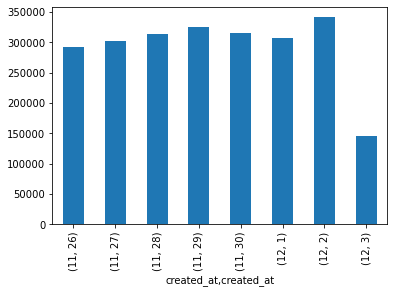

In [4]:
tweets_df.groupby([tweets_df["created_at"].dt.month, tweets_df["created_at"].dt.day]).id.count().plot(kind="bar")

## Hashtag mas populares

Primero se ordenaron los Tweets según hashtags.  Los hashtags tiene como fin clasificar un mensaje en una categoría designada por el usuario que lo creó. Distinguir si un mensaje apoya a uno u otro candidato no es una tarea fácil, por lo que decidimos usar los hashtags como proxy para determinar a quién apoya cada tweet.

Los hashtags mas populares son:

In [6]:
def top_hashtags(df):
    hashtags_dict = {}
    for index, values in df.entities.items():
        if values and ('hashtags' in values):
            hashtags = values['hashtags']       
            for hashtag in hashtags:
                # check if hashtags is in the dictionary
                tag = "#" + hashtag['tag']
                if ("boric" in tag.lower()) or ("kast" in tag.lower()):
                    if tag in hashtags_dict:
                        hashtags_dict[tag] += 1
                    else:
                        hashtags_dict[tag] = 1
    hashtags_df = pd.DataFrame.from_dict(hashtags_dict, orient='index', columns=['count'])
    return hashtags_df.sort_values(by='count', ascending=False)

In [7]:
top_hashtags_df = top_hashtags(tweets_df)
top_hashtags_df.head(20)

,count
#Boric,45269
#BoricPresidente,35257
#Kast,31339
#MujeresPorKast,21976
#TodoChileVotaKast,19090
#KastPresidente2022,17759
#TodosKast,12656
#BoricPresidente2022,7749
#BoricNoSeAtreveDebatir,7065
#kast,6617


Para nuestro análisis excluiremos los hashtags #Kast, #Boric , #kast y #boric. Esto dado que tanto un comentario positivo como negativo al respecto de los candidatos puede incluirlos.

La lista de los 10 hashtags mas populares excluyendo los hastags mencionados se ve asi:

In [8]:
hashtags_list = ['#BoricPresidente',
 '#MujeresPorKast',
 '#TodoChileVotaKast',
 '#KastPresidente2022',
 '#TodosKast',
 '#BoricPresidente2022',
 '#BoricNoSeAtreveDebatir',
 '#BoricNoSeLaPuede',
 '#BoricMiente',
 '#KastPresidente']

top_hashtags_df = top_hashtags_df[top_hashtags_df.index.isin(hashtags_list)]
top_hashtags_df

,count
#BoricPresidente,35257
#MujeresPorKast,21976
#TodoChileVotaKast,19090
#KastPresidente2022,17759
#TodosKast,12656
#BoricPresidente2022,7749
#BoricNoSeAtreveDebatir,7065
#BoricNoSeLaPuede,5610
#BoricMiente,4733
#KastPresidente,4725


<AxesSubplot:>

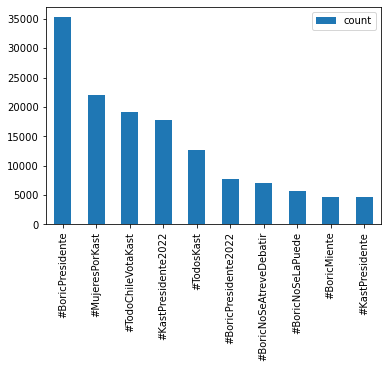

In [9]:
top_hashtags_df.plot(kind="bar")

A primera vista podemos observar que hay hashtags que apoyan directamente a un candidato y otros que se manifiestan contrarios a un candidato. 

In [10]:
hashtags_support_dict = {
 "#BoricPresidente": "Boric",
 "#MujeresPorKast": "Kast",
 "#TodoChileVotaKast": "Kast",
 "#KastPresidente2022": "Kast",
 "#TodosKast": "Kast",
 "#BoricPresidente2022": "Boric",
 "#BoricNoSeAtreveDebatir": "Kast",
 "#BoricNoSeLaPuede": "Kast",
 "#BoricMiente": "Kast",
 "#KastPresidente": "Kast"
 }

**De aqui en adelante solo trabajaremos con los tweets pertenecientos a los hashtags anteriormente mencionados**

In [11]:
# asignar cuentas a candidatos
def candidate_support(text):
    for key in hashtags_support_dict:
        if key in text:
            support =  hashtags_support_dict[key]
    if "support" not in locals():
        support = np.nan
    return support 

In [12]:
tweets_df["candidate_support"] = tweets_df.text.apply(lambda x: candidate_support(x))
tweets_df = tweets_df[tweets_df.candidate_support.notna()]
total_hashtags_users = len(tweets_df.author_id.unique())

print("Total de usuarios de los top 10 hashtags:", total_hashtags_users)

Total de usuarios de los top 10 hashtags: 30572


## Cuentas eliminadas

Antes de ver el resultado el análisis es importante destacar un hallazgo curioso: el **26,26%** del total de las cuentas analizadas en el muestreo se encuentran eliminadas. Una cuenta puede suspenderse por tres razones:

- El usuario voluntariamente cierra su cuenta
- La cuenta se encuentra inactiva por un largo periodo de tiempo
- Twitter suspende la cuenta por [violación al código de conducta](https://help.twitter.com/en/rules-and-policies/twitter-rules)

In [13]:
users_df = users_df[users_df.id_str.isin(tweets_df.author_id.unique())]
tweets_df = tweets_df.merge(users_df, how="left", left_on="author_id", right_on="id_str")

usuarios_activos = len(users_df[users_df.status == "active"])
usuarios_eliminados = len(users_df[users_df.status == "deleted"])
ratio_borrados = usuarios_eliminados / (usuarios_eliminados + usuarios_activos)

print("Total de usuarios:", total_hashtags_users)
print("Usuarios activos:", usuarios_activos)
print("Usuarios eliminados:", usuarios_eliminados)
print(f"Proporción de usuarios borrados: {(ratio_borrados * 100):.2f}%")

Total de usuarios: 30572
Usuarios activos: 22544
Usuarios eliminados: 8028
Proporción de usuarios borrados: 26.26%


<AxesSubplot:xlabel='status'>

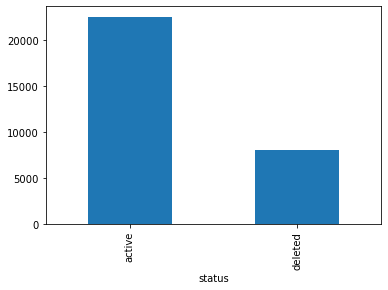

In [15]:
users_df.groupby(users_df.status).id_str.count().plot(kind="bar")

Con la información obtenida no podemos determinar la causa por la cual la cuenta ha sido desactivada. 

In [32]:
kast_top_users = len(tweets_df[tweets_df.candidate_support == "Kast"].author_id.unique())
print("Usuarios que apoyan a Kast:", kast_top_users)

kast_active_users = len(tweets_df[(tweets_df.candidate_support == "Kast") & (tweets_df.status == "active")].author_id.unique())
print(f"Usuarios que apoyan a Kast activos: {kast_active_users} equivalente al {(kast_active_users / kast_top_users)*100:.2f}% del total de usuarios")

kast_deleted_accounts = len(tweets_df[(tweets_df.candidate_support == "Kast") & (tweets_df.status == "deleted")].author_id.unique())
print(f"Usuarios que apoyan a Kast eliminados: {kast_deleted_accounts} equivalente al {(kast_deleted_accounts / kast_top_users) * 100:.2f}% del total de usuarios")

Usuarios que apoyan a Kast: 16722
Usuarios que apoyan a Kast activos: 11705 equivalente al 70.00% del total de usuarios
Usuarios que apoyan a Kast eliminados: 5017 equivalente al 30.00% del total de usuarios


<AxesSubplot:xlabel='status'>

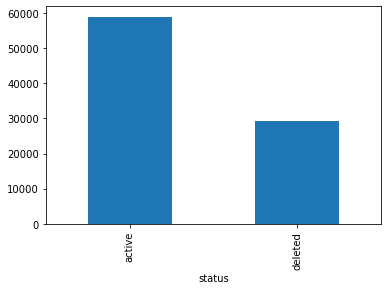

In [33]:
tweets_df[tweets_df.candidate_support == "Kast"].groupby(tweets_df.status).id_str.count().plot(kind="bar")

In [34]:
boric_top_users = len(tweets_df[tweets_df.candidate_support == "Boric"].author_id.unique())
print("Usuarios que apoyan a Boric:", boric_top_users)

boric_active_users = len(tweets_df[(tweets_df.candidate_support == "Boric") & (tweets_df.status == "active")].author_id.unique())
print(f"Usuarios que apoyan a Boric activos: {boric_active_users} equivalente al {(boric_active_users / boric_top_users)*100:.2f}% del total de usuarios")

boric_deleted_accounts = len(tweets_df[(tweets_df.candidate_support == "Boric") & (tweets_df.status == "deleted")].author_id.unique())
print(f"Usuarios que apoyan a Boric eliminados: {boric_deleted_accounts} equivalente al {(boric_deleted_accounts / boric_top_users) * 100:.2f}% del total de usuarios")

Usuarios que apoyan a Boric: 15611
Usuarios que apoyan a Boric activos: 12015 equivalente al 76.96% del total de usuarios
Usuarios que apoyan a Boric eliminados: 3596 equivalente al 23.04% del total de usuarios


<AxesSubplot:xlabel='status'>

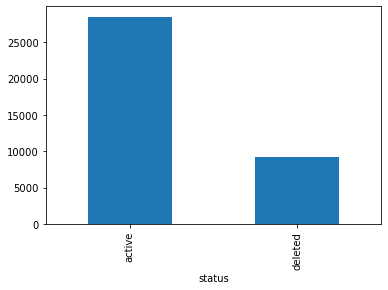

In [28]:
tweets_df[tweets_df.candidate_support == "Boric"].groupby(tweets_df.status).id_str.count().plot(kind="bar")

Las cuentas eliminadas que apoyan a Kast constituyen el 30
% del total. En el caso de Boric, un 23.04% de las cuentas fueron eliminadas. Una hipótesis es que estas cuentas han sido cerradas por usar leguaje extremadamente violento, lo cual ocurriría en el caso de ambas candidaturas.

## Bots

Nuestro objetivo principal es identificar la magnitud de la presencia de Bots en el discurso publico referente al proceso eleccionario. Para clasificar una cuenta como Bot usamos un modelo llamado [Botometer](https://botometer.osome.iu.edu/) desarrollado por el [Observatory on Social Media](https://osome.iu.edu/) de la Indiana University. Elegimos ese modelo por su extensa [documentación](https://arxiv.org/abs/1602.00975) y validación pública.

El modelo toma una cuenta de usuario de Twitter y analiza su actividad histórica para determinar qué tan probable es que esa cuenta sea un Bot. Cuando el modelo le otorga una probabilidad a una cuenta de ser Bot mayor al 50% nosotros lo clasificamos como tal.

In [35]:
kast_bot_accounts = len(tweets_df[(tweets_df.candidate_support == "Kast") & (tweets_df.universal > 0.5)].author_id.unique())
print(f"Bots que apoyan a Kast: {kast_bot_accounts} equivalente al {(kast_bot_accounts / kast_active_users) * 100:.2f}% de los usuarios activos")
boric_bot_accounts = len(tweets_df[(tweets_df.candidate_support == "Boric") & (tweets_df.universal > 0.5)].author_id.unique())
print(f"Bots que apoyan a Boric: {boric_bot_accounts} equivalente al {(boric_bot_accounts / boric_active_users) * 100:.2f}% de los usuarios activos")

Bots que apoyan a Kast: 2762 equivalente al 23.60% de los usuarios activos
Bots que apoyan a Boric: 945 equivalente al 7.87% de los usuarios activos


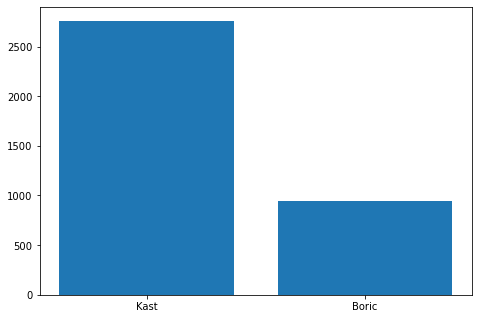

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
candidates = ["Kast", "Boric"]
bots = [kast_bot_accounts, boric_bot_accounts]
ax.bar(candidates,bots)
plt.show()

## Bots por hashtag

In [13]:
# users per hashtag
hashtags_df = pd.DataFrame(columns=["hashtag", "active", "deleted", "bots"])

for hashtag in hashtags_list:
    active_users = 0
    deleted_users = 0
    bot_users = 0
    hashtag_df = tweets_df[tweets_df.text.str.contains(hashtag)]
    hashtag_users_list = list(hashtag_df.author_id.unique())
    for user in hashtag_users_list:
        users_info_df = users_df[users_df.id_str == user]
        if users_info_df.status.values[0] == "active":
            active_users += 1
        if users_info_df.status.values[0] == "deleted":
            deleted_users += 1
        if (users_info_df.universal > 0.5).values[0]:
            bot_users += 1
    hashtags_df = hashtags_df.append({
        "hashtag": hashtag,
        "active": active_users,
        "deleted": deleted_users,
        "bots": bot_users
    }, ignore_index=True)

hashtags_df["support"] = hashtags_df.hashtag.apply(lambda x: hashtags_support_dict[x])
hashtags_df

,hashtag,active,deleted,bots,support
0,#BoricPresidente,12731,3896,1152,Boric
1,#MujeresPorKast,4488,2040,1494,Kast
2,#TodoChileVotaKast,4497,2060,1549,Kast
3,#KastPresidente2022,4722,2102,1569,Kast
4,#TodosKast,3823,1760,1393,Kast
5,#BoricPresidente2022,3016,980,192,Boric
6,#BoricNoSeAtreveDebatir,2342,1078,834,Kast
7,#BoricNoSeLaPuede,2567,1145,988,Kast
8,#BoricMiente,3515,1558,1105,Kast
9,#KastPresidente,5512,2507,1746,Kast


In [56]:
def hashtag_stats(hashtag):
    hashtag_df = tweets_df[tweets_df.text.str.contains(hashtag)]
    tweets_count = len(hashtag_df)
    users_count = len(hashtag_df.author_id.unique())
    active_users_count = len(hashtag_df[hashtag_df.status == "active"].author_id.unique())
    deleted_users_count = len(hashtag_df[hashtag_df.status == "deleted"].author_id.unique())
    bot_users_count = len(hashtag_df[hashtag_df.universal > 0.5].author_id.unique())

    active_users_ratio = active_users_count / users_count
    deleted_users_ratio = deleted_users_count / users_count
    bot_users_ratio = bot_users_count / active_users_count

    print("Hashtag:", hashtag)
    print("Tweets:", tweets_count)
    print("Número de usuarios:", users_count)
    print("Usuarios activos:", active_users_count)
    print("Usuarios eliminados:", deleted_users_count)
    print("Bots:", bot_users_count)
    print(f"Porcentaje de usuarios activos: {(active_users_ratio * 100):.2f}%")
    print(f"Porcentaje de usuarios eliminados: {(deleted_users_ratio * 100):.2f}%")
    print(f"Porcentaje de Bots: {(bot_users_ratio * 100):.2f}%")

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title = hashtag
    ax.set_ylabel = "Usuarios"
    status = ["Total", "Activos", "Eliminados", "Bots"]
    count = [users_count, active_users_count, deleted_users_count, bot_users_count]
    ax.bar(status, count)
    plt.show()
    

Hashtag: #BoricPresidente
Tweets: 39532
Número de usuarios: 16627
Usuarios activos: 12731
Usuarios eliminados: 3896
Bots: 1152
Porcentaje de usuarios activos: 76.57%
Porcentaje de usuarios eliminados: 23.43%
Porcentaje de Bots: 9.05%


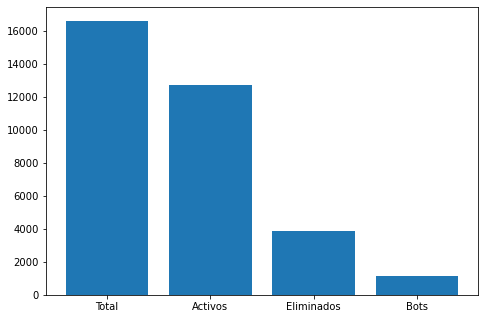

In [57]:
hashtag = "#BoricPresidente"
hashtag_stats(hashtag)

Hashtag: #MujeresPorKast
Tweets: 21457
Número de usuarios: 6528
Usuarios activos: 4488
Usuarios eliminados: 2040
Bots: 1494
Porcentaje de usuarios activos: 68.75%
Porcentaje de usuarios eliminados: 31.25%
Porcentaje de Bots: 33.29%


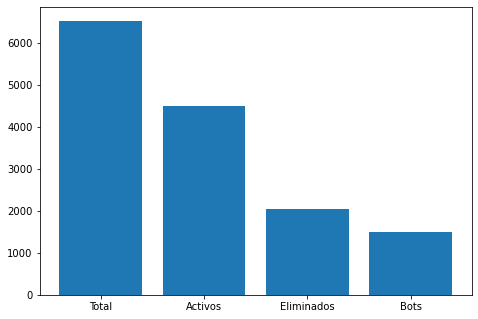

In [45]:
hashtag = "#MujeresPorKast"
hashtag_stats(hashtag)

Hashtag: #TodoChileVotaKast
Tweets: 18632
Número de usuarios: 6557
Usuarios activos: 4497
Usuarios eliminados: 2060
Bots: 1549
Porcentaje de usuarios activos: 68.58%
Porcentaje de usuarios eliminados: 31.42%
Porcentaje de Bots: 34.45%


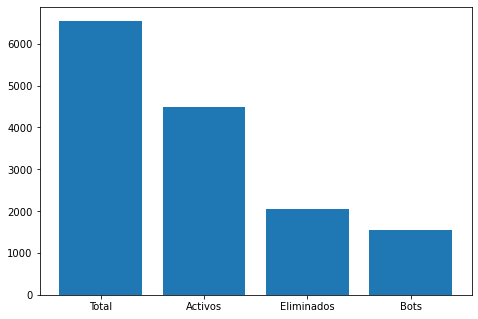

In [46]:
hashtag = "#TodoChileVotaKast"
hashtag_stats(hashtag)

Hashtag: #KastPresidente2022
Tweets: 17691
Número de usuarios: 6824
Usuarios activos: 4722
Usuarios eliminados: 2102
Bots: 1569
Porcentaje de usuarios activos: 69.20%
Porcentaje de usuarios eliminados: 30.80%
Porcentaje de Bots: 33.23%


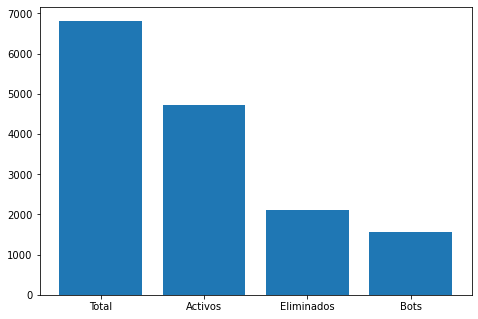

In [47]:
hashtag = "#KastPresidente2022"
hashtag_stats(hashtag)

Hashtag: #TodosKast
Tweets: 12353
Número de usuarios: 5583
Usuarios activos: 3823
Usuarios eliminados: 1760
Bots: 1393
Porcentaje de usuarios activos: 68.48%
Porcentaje de usuarios eliminados: 31.52%
Porcentaje de Bots: 36.44%


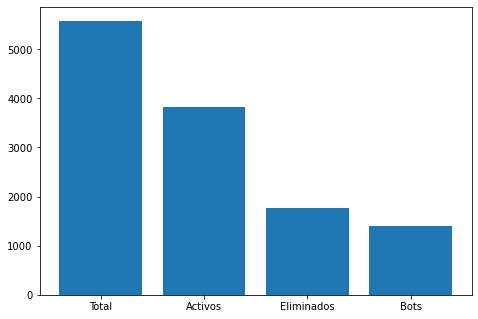

In [48]:
hashtag = "#TodosKast"
hashtag_stats(hashtag)

Hashtag: #BoricPresidente2022
Tweets: 7605
Número de usuarios: 3996
Usuarios activos: 3016
Usuarios eliminados: 980
Bots: 192
Porcentaje de usuarios activos: 75.48%
Porcentaje de usuarios eliminados: 24.52%
Porcentaje de Bots: 6.37%


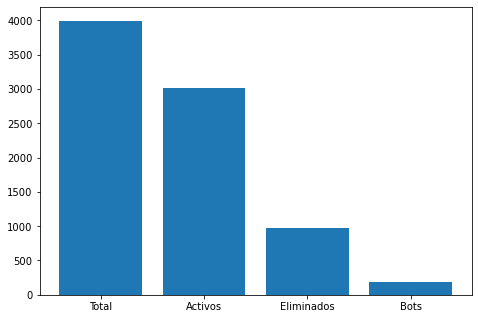

In [49]:
hashtag = "#BoricPresidente2022"
hashtag_stats(hashtag)

Hashtag: #BoricNoSeAtreveDebatir
Tweets: 7048
Número de usuarios: 3420
Usuarios activos: 2342
Usuarios eliminados: 1078
Bots: 834
Porcentaje de usuarios activos: 68.48%
Porcentaje de usuarios eliminados: 31.52%
Porcentaje de Bots: 35.61%


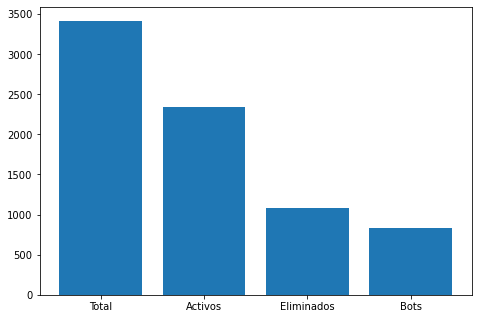

In [50]:
hashtag = "#BoricNoSeAtreveDebatir"
hashtag_stats(hashtag)

Hashtag: #BoricNoSeLaPuede
Tweets: 5610
Número de usuarios: 3712
Usuarios activos: 2567
Usuarios eliminados: 1145
Bots: 988
Porcentaje de usuarios activos: 69.15%
Porcentaje de usuarios eliminados: 30.85%
Porcentaje de Bots: 38.49%


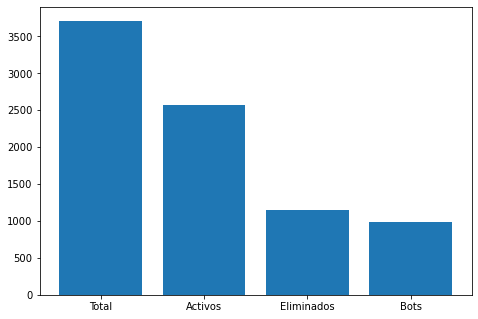

In [51]:
hashtag = "#BoricNoSeLaPuede"
hashtag_stats(hashtag)

Hashtag: #BoricMiente
Tweets: 9546
Número de usuarios: 5073
Usuarios activos: 3515
Usuarios eliminados: 1558
Bots: 1105
Porcentaje de usuarios activos: 69.29%
Porcentaje de usuarios eliminados: 30.71%
Porcentaje de Bots: 31.44%


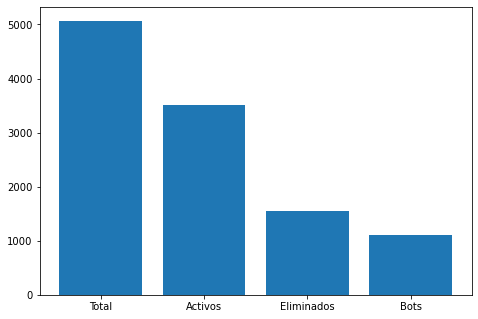

In [52]:
hashtag = "#BoricMiente"
hashtag_stats(hashtag)

Hashtag: #KastPresidente
Tweets: 22670
Número de usuarios: 8019
Usuarios activos: 5512
Usuarios eliminados: 2507
Bots: 1746
Porcentaje de usuarios activos: 68.74%
Porcentaje de usuarios eliminados: 31.26%
Porcentaje de Bots: 31.68%


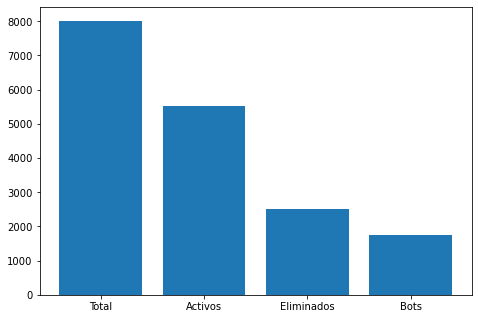

In [53]:
hashtag = "#KastPresidente"
hashtag_stats(hashtag)